# Supervised Learning  Coursework 2 - Part 2

## Importing Libraries

In [1]:
# Import libraries
import numpy as np
from scipy.stats import mode 
import cupy as cp
from matplotlib import pyplot as plt
from itertools import combinations
import seaborn as sns
import pandas as pd
import time
import json
import os

## Implementing models

### K-Nearest Neighbors

In [2]:
class KNN():
    
    """ Manual Implementation of KNN algorithm """
    
    def __init__(self, data, labels, k):
        self.k = k
        self.data = data
        self.labels = labels
        
    def calc_distance(self, point1, point2):
        """ Calculates the euclidean distance between two points """
        distance = cp.linalg.norm(cp.asarray(point1) - cp.asarray(point2), axis=1)
        return cp.sqrt(distance).get()
    
    def get_nearest_neighbors(self, test_point):
        """ Returns the k nearest neighbors indices """
        distances = self.calc_distance(self.data, test_point)
        nearest_neighbors = np.argsort(distances)[:self.k]
        return nearest_neighbors
        
    def predict(self, test_point):
        """ Predicts the class of a test point based on k nearest neighbors  """
        nearest_neighbors = self.get_nearest_neighbors(test_point)
        nearest_labels = self.labels[nearest_neighbors]
        pred = mode(nearest_labels)[0]
        return pred

### Linear Regression

In [13]:
class Linear_Regression():
    
    """ Manual Implementation of Linear Regression """
    
    def __init__(self):
        self.w = None
#         self.b = None
     
    def fit(self, X, y, add_bias_col=True):
        
        # Dimensions
        m, n = X.shape

        self.w = np.linalg.pinv(X.T @ X) @ X.T @ y

        assert self.w.shape == (n, )
        
    def predict(self, X):
        pred = X@self.w #+ self.b
        pred = np.where(pred > 0.0, 1.0, -1.0)
        return pred

### Perceptron

In [34]:
class Perceptron():
    def __init__(self):
        self.w = None
    
    def fit(self, X, y):
        
        # Dimensions
        m, n = X.shape
        
        # Weights and mistakes
        self.w = np.zeros(n)
        M = 0
        
        for t in range(m):
            # Recieve pattern
            x_t = X[t]
            
            # Predict
            pred = np.sign(np.dot(self.w, x_t))
            
            # Recieve true label
            y_t = y[t]
            
            # Update
            if y_t*pred <= 0:
                self.w += y_t*x_t
                M += 1
    
    def predict(self, X):
        pred = X @ self.w.T
        pred = np.where(pred > 0, 1.0, -1.0)
        return pred
    
    def evaluate(self, X, y):
        pred = self.predict(X)
        mistakes = np.where(pred != y, 1.0, 0.0)
        return np.mean(mistakes)

### Winnow

In [39]:
class Winnow():
    def __init__(self):
        self.w = None
    
    def fit(self, X, y):
        
        # Dimensions
        m, n = X.shape
        
        # Weights and mistakes
        self.w = np.ones(n)
        
        for t in range(m):
            # Recieve pattern
            x_t = X[t]
            
            # Predict
            pred = 1 if np.dot(self.w, x_t) >= n else 0
            
            # Recieve true label
            y_t = y[t]
            
            # Update
            if pred != y_t:
                self.w = self.w * np.power(2.0, ((y_t - pred)*x_t))
    
    def predict(self, X):
        m, n = X.shape
        pred = np.dot(X, self.w) 
        pred = np.where(pred >= n, 1.0, 0.0)
        return pred
    
    def evaluate(self, X, y):
        pred = self.predict(X)
        mistakes = np.where(pred != y, 1.0, 0.0)
        return np.mean(mistakes)

## Sample Complexity Function

In [11]:
def compute_sample_complexity(algorithm, m_max, N, n_train_sets, epsilon):
    
    sample_complexities = []
    
    for n in range(1, N+1):
        
        np.random.seed(1303)
        
        # Generate 20 training sets of size (m_max, n)
        # Values for Winnow must be from set {0, 1} while rest are {-1, +1}
        # Points generated uniformly
        if algorithm == "winnow":
            X_train = np.random.choice([0, 1], size=(n_train_sets, m_max, n))
            X_test = np.random.choice([0, 1], size=(600, n))
        else:
            X_train = np.random.choice([-1, 1], size=(n_train_sets, m_max, n))
            X_test = np.random.choice([-1, 1], size=(600, n))
        
        for m in range(1, m_max):
        
            # Select subsets of the data
            X_subsets = X_train[:, :m, :]

            assert X_subsets.shape == (n_train_sets, m, n)
            
            # Train specified algorithm
            if algorithm == "1NN":
                
                total_error = 0
                
                for i in range(n_train_sets):
                    
                    # Setup model
                    model = KNN(X_subsets[i], X_subsets[i, :, 0], k=1)
                    
                    mistakes = 0
                    # Predict on test points
                    for t in range(len(X_test)):
                        pred = model.predict(X_test[t])
                        mistakes += 1 if pred != X_test[t, 0] else 0

                    # Compute generalization error for the single model
                    total_error += mistakes / len(X_test)
                
                # Compute generalization error
                GE = total_error / n_train_sets
                
                # Break out of loop if the GE is <= epsilon
                if GE <= epsilon:
                    sample_complexities.append(m)
                    print("Sample complexity for n = {} : {}...GE = {}".format(n, m, GE))
                    break
                
            elif algorithm == "LR":
                
                total_error = 0
                
                for i in range(n_train_sets):
                    
                    # Setup model
                    model = Linear_Regression()

                    # Fit model
                    model.fit(X_subsets[i], X_subsets[i, :, 0])

                    # Predict on test points
                    preds = model.predict(X_test)

                    # Compute generalization error for the single model
                    mistakes = np.where(preds != X_test[:, 0], 1.0, 0.0)

                    total_error += np.mean(mistakes)
                
                # Compute generalization error
                GE = total_error / n_train_sets
                
                # Break out of loop if the GE is <= epsilon
                if GE <= epsilon:
                    sample_complexities.append(m)
                    print("Sample complexity for n = {} : {}...GE = {}".format(n, m, GE))
                    break
                
            elif algorithm == "perceptron":
                
                total_error = 0
                
                for i in range(n_train_sets):
                    
                    # Setup model
                    model = Perceptron()

                    # Fit model
                    model.fit(X_subsets[i], X_subsets[i, :, 0])

                    # Predict on test points
                    preds = model.predict(X_test)

                    # Compute generalization error for the single model
                    mistakes = np.where(preds != X_test[:, 0], 1.0, 0.0)
                    total_error += np.mean(mistakes)
                
                # Compute generalization error
                GE = total_error / n_train_sets
                
                # Break out of loop if the GE is <= epsilon
                if GE <= epsilon:
                    sample_complexities.append(m)
                    print("Sample complexity for n = {} : {}...GE = {}".format(n, m, GE))
                    break
                
            elif algorithm == "winnow":
                
                total_error = 0
                
                for i in range(n_train_sets):
                    
                    # Setup model
                    model = Winnow()

                    # Fit model
                    model.fit(X_subsets[i], X_subsets[i, :, 0])

                    # Predict on test points
                    preds = model.predict(X_test)

                    # Compute generalization error for the single model
                    mistakes = np.where(preds != X_test[:, 0], 1.0, 0.0)
                    total_error += np.mean(mistakes)
                
                # Compute generalization error
                GE = total_error / n_train_sets
                
                # Break out of loop if the GE is <= epsilon
                if GE <= epsilon:
                    sample_complexities.append(m)
                    print("Sample complexity for n = {} : {}...GE = {}".format(n, m, GE))
                    break
                
    return sample_complexities

## Compute Sample Complexity for Least Squares Regression

In [16]:
sample_complexities_LR = compute_sample_complexity(algorithm="LR", m_max=1000, n_train_sets=100, N=100, epsilon=0.1)

Sample complexity for n = 1 : 1...GE = 0.0
Sample complexity for n = 2 : 1...GE = 0.0
Sample complexity for n = 3 : 2...GE = 0.07274999999999998
Sample complexity for n = 4 : 4...GE = 0.06701666666666667
Sample complexity for n = 5 : 5...GE = 0.05935000000000001
Sample complexity for n = 6 : 5...GE = 0.09420000000000002
Sample complexity for n = 7 : 6...GE = 0.07296666666666671
Sample complexity for n = 8 : 6...GE = 0.08501666666666668
Sample complexity for n = 9 : 6...GE = 0.0956666666666666
Sample complexity for n = 10 : 7...GE = 0.09805000000000003
Sample complexity for n = 11 : 8...GE = 0.06629999999999998
Sample complexity for n = 12 : 9...GE = 0.06263333333333333
Sample complexity for n = 13 : 9...GE = 0.08378333333333333
Sample complexity for n = 14 : 9...GE = 0.09143333333333337
Sample complexity for n = 15 : 10...GE = 0.09333333333333331
Sample complexity for n = 16 : 10...GE = 0.09611666666666667
Sample complexity for n = 17 : 12...GE = 0.07501666666666666
Sample complexity f

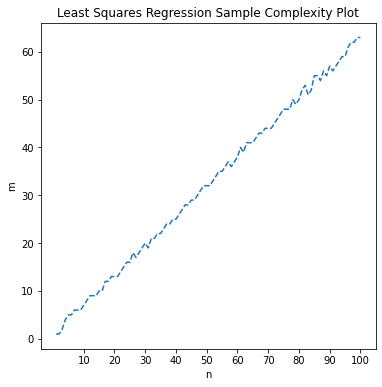

In [32]:
plt.figure(figsize=(6, 6))
plt.plot(np.arange(1, len(sample_complexities_LR)+1), sample_complexities_LR, linestyle="--")
plt.xticks(np.arange(10, len(sample_complexities_LR), 10))
plt.xlabel("n")
plt.ylabel("m")
plt.title("Least Squares Regression Sample Complexity Plot")
plt.show()

## Compute Sample Complexity for Perceptron

In [35]:
sample_complexities_per = compute_sample_complexity(algorithm="perceptron", m_max=1000, n_train_sets=100, N=100, epsilon=0.1)

Sample complexity for n = 1 : 1...GE = 0.0
Sample complexity for n = 2 : 3...GE = 0.07808333333333334
Sample complexity for n = 3 : 4...GE = 0.09844999999999997
Sample complexity for n = 4 : 5...GE = 0.09139999999999998
Sample complexity for n = 5 : 7...GE = 0.09518333333333334
Sample complexity for n = 6 : 9...GE = 0.08443333333333337
Sample complexity for n = 7 : 10...GE = 0.0863166666666667
Sample complexity for n = 8 : 11...GE = 0.09634999999999999
Sample complexity for n = 9 : 14...GE = 0.09064999999999998
Sample complexity for n = 10 : 15...GE = 0.09918333333333335
Sample complexity for n = 11 : 17...GE = 0.09536666666666667
Sample complexity for n = 12 : 20...GE = 0.09855
Sample complexity for n = 13 : 22...GE = 0.09729999999999997
Sample complexity for n = 14 : 24...GE = 0.09700000000000003
Sample complexity for n = 15 : 25...GE = 0.09875000000000003
Sample complexity for n = 16 : 26...GE = 0.09565
Sample complexity for n = 17 : 27...GE = 0.09768333333333334
Sample complexity f

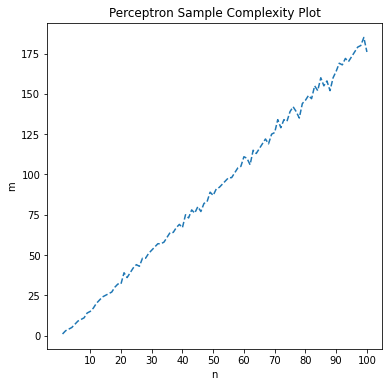

In [37]:
plt.figure(figsize=(6, 6))
plt.plot(np.arange(1, len(sample_complexities_per)+1), sample_complexities_per, linestyle="--")
plt.xticks(np.arange(10, len(sample_complexities_per)+1, 10))
plt.xlabel("n")
plt.ylabel("m")
plt.title("Perceptron Sample Complexity Plot")
plt.show()

## Compute sample complexities for winnow

In [40]:
sample_complexities_winnow = compute_sample_complexity(algorithm="winnow", m_max=1000, N=100, n_train_sets=100, epsilon=0.1)

Sample complexity for n = 1 : 1...GE = 0.0
Sample complexity for n = 2 : 4...GE = 0.07388333333333333
Sample complexity for n = 3 : 10...GE = 0.08468333333333336
Sample complexity for n = 4 : 9...GE = 0.0830333333333333
Sample complexity for n = 5 : 14...GE = 0.09411666666666672
Sample complexity for n = 6 : 16...GE = 0.09576666666666664
Sample complexity for n = 7 : 15...GE = 0.09984999999999998
Sample complexity for n = 8 : 16...GE = 0.09429999999999998
Sample complexity for n = 9 : 16...GE = 0.09386666666666668
Sample complexity for n = 10 : 18...GE = 0.09753333333333332
Sample complexity for n = 11 : 20...GE = 0.09555000000000004
Sample complexity for n = 12 : 19...GE = 0.09425000000000003
Sample complexity for n = 13 : 23...GE = 0.08383333333333327
Sample complexity for n = 14 : 24...GE = 0.09308333333333334
Sample complexity for n = 15 : 21...GE = 0.09976666666666661
Sample complexity for n = 16 : 21...GE = 0.09898333333333335
Sample complexity for n = 17 : 20...GE = 0.0955500000

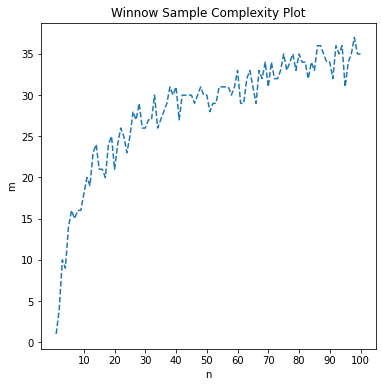

In [41]:
plt.figure(figsize=(6, 6))
plt.plot(np.arange(1, len(sample_complexities_winnow)+1), sample_complexities_winnow, linestyle="--")
plt.xticks(np.arange(10, len(sample_complexities_winnow)+1, 10))
plt.xlabel("n")
plt.ylabel("m")
plt.title("Winnow Sample Complexity Plot")
plt.show()

## Compute sample complexities for 1NN

In [4]:
sample_complexities_1NN = compute_sample_complexity(algorithm="1NN", m_max=2000, N=15, n_train_sets=20, epsilon=0.1)

Sample complexity for n = 1 : 3...GE = 0.075
Sample complexity for n = 2 : 5...GE = 0.0865
Sample complexity for n = 3 : 11...GE = 0.09591666666666668
Sample complexity for n = 4 : 12...GE = 0.09374999999999999
Sample complexity for n = 5 : 23...GE = 0.09525
Sample complexity for n = 6 : 29...GE = 0.09791666666666668
Sample complexity for n = 7 : 51...GE = 0.09658333333333334
Sample complexity for n = 8 : 80...GE = 0.09533333333333334
Sample complexity for n = 9 : 119...GE = 0.09741666666666665
Sample complexity for n = 10 : 172...GE = 0.09750000000000003
Sample complexity for n = 11 : 259...GE = 0.1
Sample complexity for n = 12 : 341...GE = 0.09891666666666668
Sample complexity for n = 13 : 549...GE = 0.09966666666666665
Sample complexity for n = 14 : 865...GE = 0.09975000000000002
Sample complexity for n = 15 : 1201...GE = 0.09983333333333333


KeyboardInterrupt: 

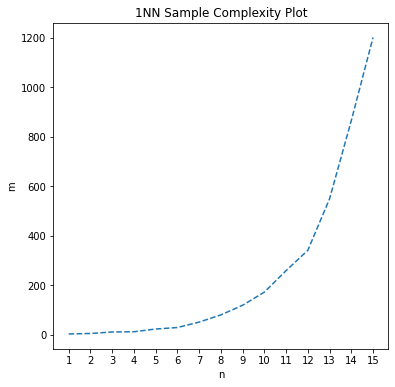

In [42]:
plt.figure(figsize=(6, 6))
plt.plot(np.arange(1, len(sample_complexities)+1), sample_complexities, linestyle="--")
plt.xticks(np.arange(1, len(sample_complexities)+1))
plt.xlabel("n")
plt.ylabel("m")
plt.title("1NN Sample Complexity Plot")
plt.show()